# CS166 Final Project

This simulation provides a simplified model for international trade. It creates a network of (by default 10) countries, each maintaining (by default) 3 firms that produce and consume a certain choice of products. 

An analysis of changing the openness of the economy (open, closed) and the stage of the cycle (boom, bust) shows that being an open economy is beneficial during a boom cycle, but harmful during bust. Outcome variables are total trade volume and total GDP.


Anna Pauxberger

20 April 2018

In [1]:
import random
import numpy as np
import string
import matplotlib.pylab as plt
%matplotlib inline
import scipy

In [2]:
class Network:
    '''A network of countries that can trade excess/ shortage products at each
    iteration. Requires countries in the form of a list of objects as an argument.
    Computes yearly and total trade across the network.'''
    
    def __init__(self, countries):
        self.countries = countries
        self.products = np.unique(np.concatenate(([c.products for c in countries])))
        for c in self.countries: c.calculate_total()
        self.total_trade = []
        self.total_GDP = 0
        
    def __repr__(self):
        return(f'Products: {self.products}, Countries: {self.countries}')
        
    def step(self):
        '''Iterates over each unique country combination to perform trade.'''
        self.yearly_trade = 0
        self.calculate_total_GDP()
        for i, c1 in enumerate(self.countries):
            for j in range(i+1, len(self.countries)): 
                c2 = self.countries[j]
                self.trade(c1, c2)
        
        # update product_count (=dictionary of excess/ shortage) for each country
        for c in self.countries: c.calculate_total()
        # track yearly trade
        self.total_trade.append(self.yearly_trade)
        # shuffle countries to randomize order of trade
        np.random.shuffle(self.countries)
    
    def trade(self, c1, c2):
        '''Countries brute-force trade their total excess/ shortaged products.
        Product count is the sum of all excess/ shortaged products of all firms.'''

        products = [k for k in c1.products if k in c2.products]
        trade_propensity = min(c1.trade_propensity, c2.trade_propensity)
        
        for p in products:
            c1_status = c1.product_count[p]
            c2_status = c2.product_count[p]
            # negative = shortage, positive = excess
            if c1_status < 0 and c2_status > 0:
                trade_volume = np.ceil(min(-c1_status, c2_status)*trade_propensity)
                c1.product_count[p] += trade_volume
                c2.product_count[p] -= trade_volume
                self.yearly_trade += trade_volume
            if c2_status < 0 and c1_status > 0:
                trade_volume = np.ceil(min(c1_status, -c2_status)*trade_propensity)
                c2.product_count[p] += trade_volume
                c1.product_count[p] -= trade_volume
                self.yearly_trade += trade_volume

    def calculate_total_GDP(self):
        self.total_GDP = 0
        for c in self.countries:
            self.total_GDP += c.calculate_domestic_GDP()
        self.total_GDP += self.yearly_trade
        return self.total_GDP

class Country:
    '''A country contains firms and maintains a product count of its excess/ shortage
    products across all firms.'''
    
    def __init__(self, name, firms, trade_propensity):
        self.name = name
        self.firms = firms
        self.products = np.unique(np.concatenate(([f.products for f in firms])))
        self.product_count = {p:0 for p in self.products}
        self.trade_propensity = trade_propensity
        
    def __repr__(self):
        return(f'Country {self.name}:, '+ f'firms:{self.firms}, '+ f'products:{self.products}')
    
    def calculate_total(self):
        '''Calculates the total usage of products across firms to update the product count.'''
        for f in self.firms:
            f.calculate_usage()
            for p in f.products:
                self.product_count[p] += f.product_usage[p]
                
    def return_total(self):
        '''Returns a list of all exchanges firms in a country want to engage in 
        (=values of products of calculate_total()).'''

        return [self.product_count.get(p) for p in self.product_count]
    
    def calculate_domestic_GDP(self):
        '''Calculates local GDP by taking total usage of products across firms, minus the 
        shortages and consumption which will only count towards GDP if traded.'''
        
        self.domestic_trade = 0
        
        domestic_usage = 0 #production or consumption of goods
        for f in self.firms:
            product_baseline = f.product_baseline
            for p in f.product_baseline:
                quantity = product_baseline.get(p)
                domestic_usage += abs(quantity) #absolute value of quantity consumed/ produced per product per firm

        excess_and_shortage = self.return_total() # net usage (produce 10, use 5 --> 5 excess)
        excess_and_shortage = sum([np.abs(number) for number in excess_and_shortage])
        self.domestic_trade = domestic_usage - excess_and_shortage
        return self.domestic_trade

                
class Firm:
    '''A firm can produce and consume 3 different products. The baseline of this consumption
    and production is taken as an input argument. Actual product usage (consumption and 
    production) is updated depending on the cycle (boom or bust) and the pace of the economy.'''
    
    def __init__(self, name, product_baseline, cycle, pace):
        self.name = name
        self.product_baseline = product_baseline # dictionary of product and usage
        self.products = [k for k in self.product_baseline.keys()]

        self.cycle = cycle
        self.pace = pace
        
    def __repr__(self):
        return(f'{self.name}')
        
    def calculate_usage(self):
        self.product_usage = self.product_baseline
        
        for p in self.products:
            if random.random() < self.pace:
                self.product_usage[p] = self.product_baseline[p]*self.cycle
            else:
                self.product_usage[p] = self.product_baseline[p]

        # To build the next baseline based on the previous, uncomment the next line.
#         self.product_baseline = self.product_usage #dependent on previous year

In [3]:
# Helper Functions

def create_firms(cycle, pace = 0.5, firms = 3):
    '''Creates firm instances to be used for creating countries. A firm's trading
    capacity (product usage as measured by consumption and production) depends on the 
    state of the cycle ('boom', 'bust').
    
    default pace: 0.5
    default number of firms: 3
    '''
    
    firms_and_baselines = {
        "cow_farm": {'grass': -10, 'cows':10},
        "grass_farm": {'fertilizer': -10, 'grass':10},
        "slaughter_house": {'cows': -10, 'meat':10},
        "restaurant": {'meat': -10, 'money':10},
        "fertilizer": {'money': -10, 'fertilizer':10}
    }

    chosen_firms = [random.choice(list(firms_and_baselines.keys())) 
                    for i in range(firms)]
    final_firms = []
    cycle = cycle
    pace = pace
    
    for firm in chosen_firms:
        product_baseline = firms_and_baselines[firm]
        initiated_firm = Firm(firm, product_baseline, cycle, pace)
        final_firms.append(initiated_firm)
    return final_firms

def create_countries(economy_cycle, economy_trade, pace = 0.5, nr_countries = 10):
    '''Creates country instances based on created firms to be used for creating a 
    network. A country's trade propensity depends on the economy_trade, for which an 
    economy can be 'open' or 'closed. 

    default pace: 0.5
    default number of countries: 10
    '''
    
    if economy_trade == 'open':
        trade_propensity = 1/abs(np.random.normal(10,2))
    elif economy_trade == 'closed':
        trade_propensity = 1/abs(np.random.normal(100, 20))
    else:
        print('error')
    
    if economy_cycle == 'boom':
        cycle = 1.2
    elif economy_cycle == 'bust':
        cycle = 0.8
        
    countries = []
    for x in range(nr_countries):
        name = string.ascii_uppercase[x]
        firms = create_firms(cycle, pace)
        new_country = Country(name, firms, trade_propensity)
        countries.append(new_country)
    return countries

In [4]:
# example simulation
def single_simulation(economy_cycle='boom', 
               pace=0.5, 
               economy_trade = 'open', 
               time=10):
    countries = create_countries(economy_cycle, economy_trade)
    agriculture = Network(countries)
    for i in range(time):
        agriculture.step()
    return agriculture.total_trade, agriculture.total_GDP

single_simulation()

([69.0, 123.0, 159.0, 201.0, 236.0, 276.0, 312.0, 354.0, 415.0, 477.0],
 -3689.5281720115177)

# Effects on Total Trade

In [5]:
def trade_simulation(economy_cycle, economy_trade):

    results = []
    for trial in range(1000):
        total_trade = single_simulation(economy_cycle = economy_cycle, 
                                        economy_trade = economy_trade)[0]
        results.append(total_trade[-1])

    print('Mean:', scipy.mean(results))
    print('Median:', scipy.median(results))
    print('95%% confidence interval: [%.2f, %.2f]' % tuple(scipy.percentile(results, [2.5, 97.5])))

    plt.hist(results, bins=20)
    plt.title(f"trade volume: {economy_cycle} cycle, {economy_trade} economy")
    plt.xlabel("volume traded (units)")
    plt.ylabel("frequency")
    plt.axvline(x=scipy.mean(results), color='k')
    plt.show()

Mean: 400.973
Median: 395.0
95% confidence interval: [211.97, 623.05]


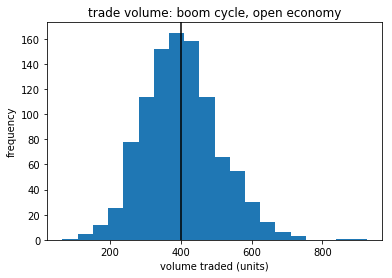

Mean: 56.576
Median: 56.5
95% confidence interval: [28.98, 86.00]


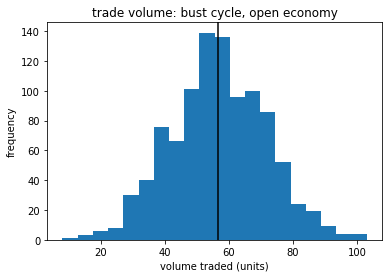

Mean: 121.929
Median: 120.0
95% confidence interval: [73.00, 181.02]


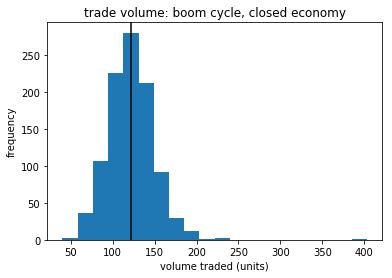

Mean: 60.142
Median: 60.0
95% confidence interval: [32.00, 86.00]


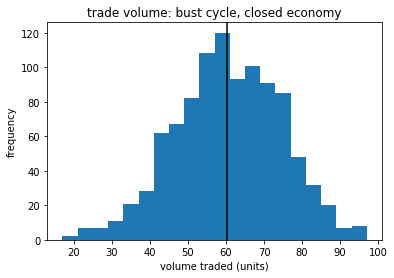

In [6]:
trade_simulation('boom', 'open')
trade_simulation('bust', 'open')
trade_simulation('boom', 'closed')
trade_simulation('bust', 'closed')

# Effects on Total GDP

In [7]:
def GDP_simulation(economy_cycle, economy_trade):

    results = []
    for trial in range(1000):
        total_GDP = single_simulation(economy_cycle = economy_cycle, 
                                        economy_trade = economy_trade)[1]
        results.append(total_GDP)

    print('Mean:', scipy.mean(results))
    print('Median:', scipy.median(results))
    print('95%% confidence interval: [%.2f, %.2f]' % tuple(scipy.percentile(results, [2.5, 97.5])))

    plt.hist(results, bins=20)
    plt.title(f"trade volume: {economy_cycle} cycle, {economy_trade} economy")
    plt.xlabel("volume traded (units)")
    plt.ylabel("frequency")
    plt.axvline(x=scipy.mean(results), color='k')
    plt.show()

Mean: -4850.2460491916445
Median: -4653.887870607357
95% confidence interval: [-8411.94, -2188.42]


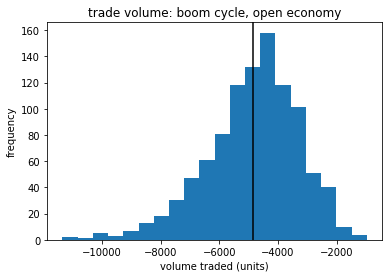

Mean: -657.1464515798092
Median: -625.2429960028162
95% confidence interval: [-1174.82, -291.19]


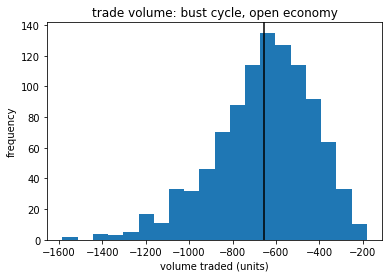

Mean: -7291.005151496701
Median: -7183.120046688662
95% confidence interval: [-11131.03, -4326.37]


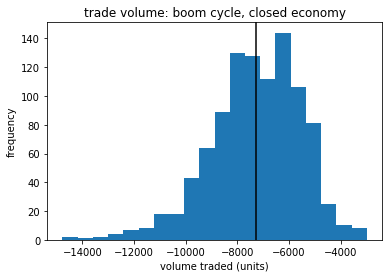

Mean: -919.8318921191421
Median: -895.0739067699201
95% confidence interval: [-1324.66, -612.36]


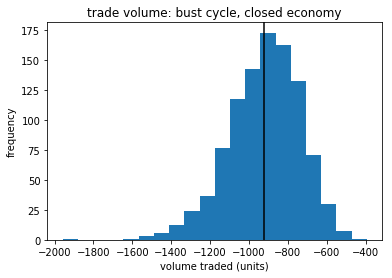

In [8]:
GDP_simulation('boom', 'open')
GDP_simulation('bust', 'open')
GDP_simulation('boom', 'closed')
GDP_simulation('bust', 'closed')